**Random Forest**

In [1]:
#importing all the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix,ConfusionMatrixDisplay,roc_auc_score,roc_curve,auc,precision_recall_curve,mean_absolute_error,log_loss,jaccard_score,matthews_corrcoef
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import  GridSearchCV

In [3]:
#loading the transformed Data Set
solar_data = pd.read_csv(r"C:\Users\bathl\OneDrive\Documents\SJSU\Machine_Learning\Project\solar_data_transformed18.csv")

In [5]:
# Exclude the target and ID column from the PCA analysis
X = solar_data.drop(['InstallType','ID'], axis=1)

# Prepare data for classification
X_train, X_test, y_train, y_test = train_test_split(X, solar_data['InstallType'], test_size=0.3, random_state=42)

rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train, y_train)
y_pred_rf = rf_classifier.predict(X_test)

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)

#target column values' mapping
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}

target_names = [class_mapping[label] for label in sorted(class_mapping.keys())]

rf_report = classification_report(y_test, y_pred_rf, target_names=target_names)

print("Random Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:\n", rf_report)


Random Forest Accuracy: 0.9358024691358025
Random Forest Classification Report:
               precision    recall  f1-score   support

      Ground       0.95      0.95      0.95       647
     Parking       0.91      0.94      0.93       416
     Rooftop       0.94      0.91      0.93       557

    accuracy                           0.94      1620
   macro avg       0.93      0.94      0.93      1620
weighted avg       0.94      0.94      0.94      1620



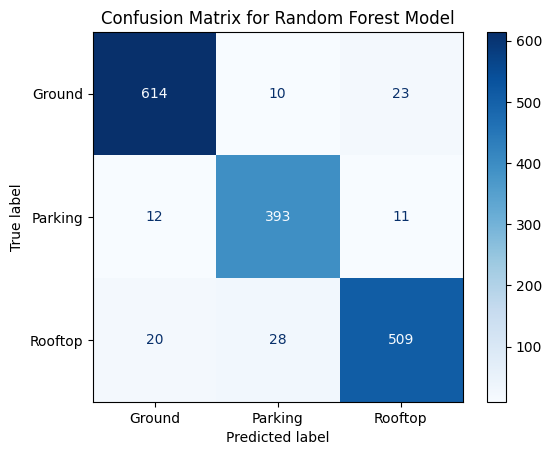

In [7]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)

disp.plot(cmap='Blues')
# Add labels to the plot
class_names = ['Ground', 'Parking', 'Rooftop']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

In [9]:
# Random Forest Tuning
rf_param_grid = {
    'n_estimators': [100, 200,300],
    'max_depth': [10, 20,30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=rf_param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1
)
rf_grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, 30, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

**Evaluation Metrics**

In [12]:
# Best parameters and performance
best_rf = rf_grid_search.best_estimator_
y_pred_rf_tuned = best_rf.predict(X_test)
rf_tuned_accuracy = accuracy_score(y_test, y_pred_rf_tuned)

#target column values' mapping
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}

target_names = [class_mapping[label] for label in sorted(class_mapping.keys())]

rf_tuned_report = classification_report(y_test, y_pred_rf_tuned, target_names=target_names)

print("Tuned Random Forest Accuracy:", rf_tuned_accuracy)
print("Tuned Random Forest Classification Report:\n", rf_tuned_report)


Tuned Random Forest Accuracy: 0.9364197530864198
Tuned Random Forest Classification Report:
               precision    recall  f1-score   support

      Ground       0.95      0.95      0.95       647
     Parking       0.91      0.94      0.93       416
     Rooftop       0.94      0.91      0.93       557

    accuracy                           0.94      1620
   macro avg       0.93      0.94      0.93      1620
weighted avg       0.94      0.94      0.94      1620



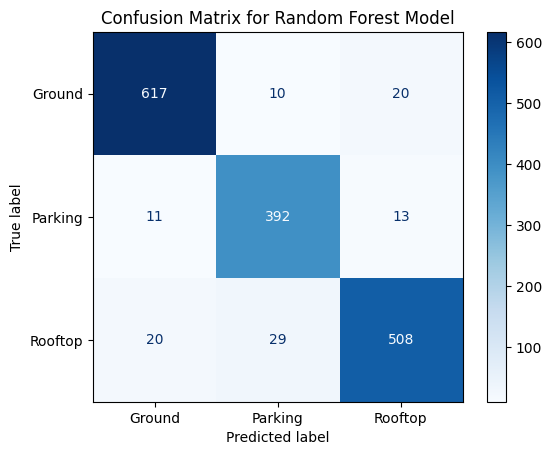

In [14]:
#Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf_tuned)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap='Blues')

# Add labels to the plot
class_names = ['Ground', 'Parking', 'Rooftop']
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

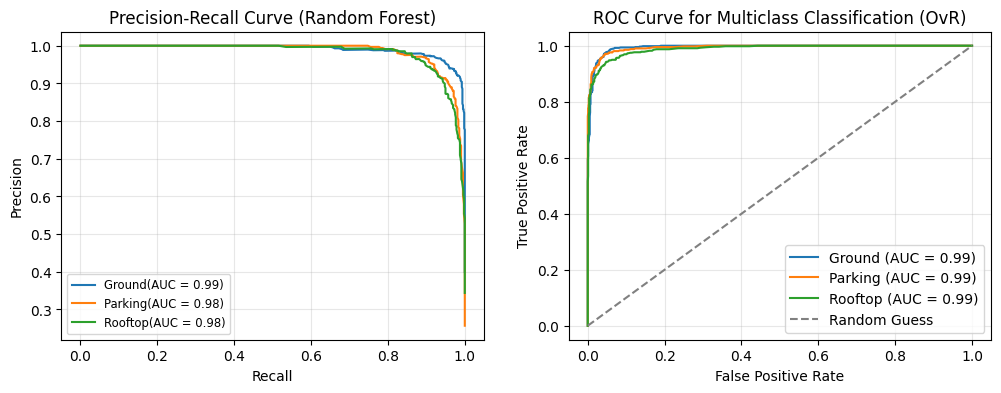

In [16]:
#Define a mapping for class names
class_mapping = {
    0: "Ground",
    1: "Parking",
    2: "Rooftop"
}
# Ensure classes are correctly labeled and binarized
n_classes = len(best_rf.classes_)  # Number of classes
y_test_bin = label_binarize(y_test, classes=best_rf.classes_)  # Binarize y_test

# Ensure probabilities are available for all classes
y_prob = best_rf.predict_proba(X_test)  # Predicted probabilities

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 4)) 

# Plot Precision-Recall Curves
for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_prob[:, i])
    pr_auc = auc(recall, precision)
    class_name = class_mapping[best_rf.classes_[i]] 
    axes[0].plot(recall, precision, label=f"{class_name}(AUC = {pr_auc:.2f})")

axes[0].set_title("Precision-Recall Curve (Random Forest)", fontsize=12)
axes[0].set_xlabel("Recall", fontsize=10)
axes[0].set_ylabel("Precision", fontsize=10)
axes[0].legend(loc="lower left", fontsize='small')
axes[0].grid(alpha=0.3)


# Plotting the ROC Curve for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR and TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC
    class_name = class_mapping[best_rf.classes_[i]]
    plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc:.2f})")

# Plot the diagonal line for random guessing
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")

# Customize the plot
plt.title("ROC Curve for Multiclass Classification (OvR)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Precision-Recall Curve:

1. All three classes (Ground, Parking, and Rooftop) have nearly perfect PR curves. Precision remains high (>0.9) even as recall increases to 1.0.
2. This means the model accurately predicts positives without significant false positives or false negatives across all recall levels.
3. Slight differences in AUC suggest the model may perform marginally better for the Ground class compared to Parking and Rooftop.

ROC-AUC Curve:

1. All three classes (Ground, Parking, and Rooftop) have curves that hug the top-left corner of the graph, showing strong discrimination capability.
2. For all classes, the ROC curve suggests the model achieves high TPR while keeping the FPR very low.
3. The nearly identical AUC values indicate that the model does not favor one class over others.

In [19]:
#Use roc_auc_score with 'ovr' or 'ovo' for multiclass
print("ROC-AUC Score (OVR):", roc_auc_score(y_test, y_prob, multi_class='ovr'))
print("ROC-AUC Score (OVO):", roc_auc_score(y_test, y_prob, multi_class='ovo'))

ROC-AUC Score (OVR): 0.9920990661646929
ROC-AUC Score (OVO): 0.9919713680303875


In [21]:
print("Matthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred_rf_tuned))

Matthews Correlation Coefficient: 0.9033688655018871


In [23]:
print("Jaccard Score (Macro):", jaccard_score(y_test, y_pred_rf_tuned, average='macro'))

Jaccard Score (Macro): 0.877528303072026


In [25]:
#Passing the true labels explicitly
unique_classes = best_rf.classes_
print("Log Loss:", log_loss(y_test, y_prob, labels=unique_classes))

Log Loss: 0.19582564230698787


In [27]:
mae = mean_absolute_error(y_test, y_pred_rf_tuned)
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Absolute Error (MAE): 0.0883


**RandomForest Insights**

The tuned Random Forest model performs slightly better than the initial model, indicating that hyperparameter optimization indeed increased the effectiveness of this model.

1. Accuracy improved from 93.58% to 93.64%, indicating fine-tuning has reduced minor classification errors.
2. Precision, Recall, and F1-scores are all around 0.94, indicating consistent performance across all classes.
3. These metrics remain robust even after tuning, maintaining balance across the dataset.

**Feature Importance**

In [33]:
#Calculating the feature importance for the target feature

clf = RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(solar_data.drop(['InstallType','ID'],axis=1), solar_data['InstallType'])
feature_importances = pd.DataFrame(clf.feature_importances_,
                                   index = solar_data.drop(['InstallType','ID'],axis=1).columns,
                                   columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                      importance
DistSub_100_binned      0.205705
Percent_CAISO           0.190485
Substation_200          0.095653
Area                    0.059427
Percent_100             0.056731
Class                   0.056726
Length                  0.053929
HIFLD_200               0.046581
HIFLD_CAISO             0.045458
HIFLD_100               0.041923
DistSub_200_binned      0.036020
County                  0.024962
Substation_100          0.024593
SolarTech               0.016942
DistSub_CAISO_binned    0.015058
Substation_CAISO        0.013092
UrbanRural              0.009207
Percent_200             0.007508


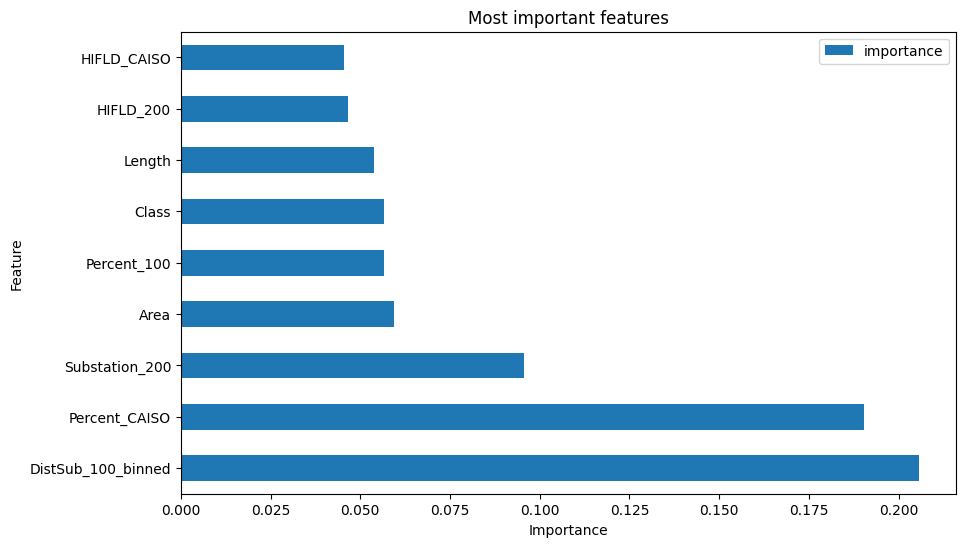

In [35]:
top_features = feature_importances.sort_values('importance', ascending=False).iloc[:9, :]

# Create a horizontal bar plot of the top 18 features
fig, ax = plt.subplots(figsize=(10, 6))
top_features.plot.barh(ax=ax)

# Set plot title and axis labels
ax.set_title('Most important features')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')

# Show the plot
plt.show()